# 聲紋辨識(Speaker Recognition)

## 載入套件

In [21]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

## 下載資料集並解壓縮

In [2]:
# Get the data from https://www.kaggle.com/kongaevans/speaker-recognition-dataset/
# and save it to ./speaker-recognition-dataset.zip
# then unzip it to ./16000_pcm_speeches
!pip install kaggle
!kaggle datasets download -d kongaevans/speaker-recognition-dataset
!unzip -qq speaker-recognition-dataset.zip

^C



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


^C


[speaker-recognition-dataset.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in speaker-recognition-dataset.zip,
        and cannot find speaker-recognition-dataset.zip.zip, period.


 41951232/182082353 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

 45465600/182082353 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

 56442880/182082353 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

 75505664/182082353 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

 92282880/182082353 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

109060096/182082353 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

132341760/182082353 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

142614528/182082353 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

165273600/182082353 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

176168960/182082353 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## 顯示次目錄名稱

In [22]:
DATASET_PATH = './16000_pcm_speeches'
label_names = np.array(tf.io.gfile.listdir(str(DATASET_PATH)))
label_names = [x for x in label_names if x not in 
               ['tf_Wav_reader.py', '_background_noise_', 'other']]
print('label_names:', label_names)

label_names: ['Benjamin_Netanyau', 'Jens_Stoltenberg', 'Julia_Gillard', 'Magaret_Tarcher', 'Nelson_Mandela']


## 建立資料集

In [23]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=DATASET_PATH,
    class_names = label_names,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 7501 files belonging to 5 classes.
Using 6001 files for training.
Using 1500 files for validation.

label names: ['Benjamin_Netanyau' 'Jens_Stoltenberg' 'Julia_Gillard' 'Magaret_Tarcher'
 'Nelson_Mandela']


## 查看音檔規格，每一筆含 (batch, samples, channels)

In [24]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

## 刪除channels維度

In [25]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

## utils.audio_dataset_from_directory函數只傳回兩個分割，進一步使用shard將val_ds分割測試集與驗證集

In [26]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

## 觀察第一批資料

In [27]:
for example_audio, example_labels in train_ds.take(1):  
    print(example_audio.shape)
    print(example_labels.shape)
    print(example_labels)

(64, 16000)
(64,)
tf.Tensor(
[2 2 2 2 0 3 0 4 2 0 4 2 0 0 0 0 3 0 1 2 3 4 0 3 1 1 4 3 1 2 4 2 2 4 1 2 2
 4 2 3 0 1 1 4 4 3 3 0 1 3 2 0 1 3 2 2 3 4 2 4 3 3 0 1], shape=(64,), dtype=int32)


## 觀察第一批資料波形

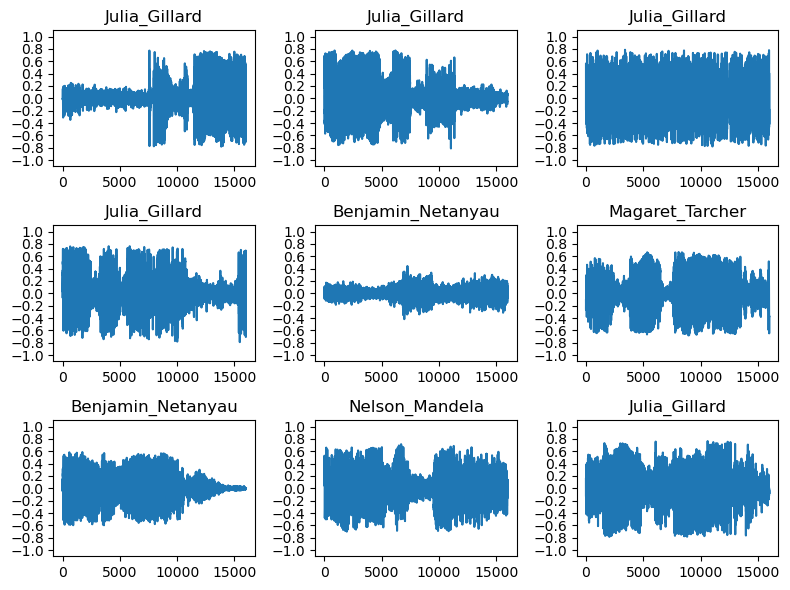

In [28]:
plt.figure(figsize=(8, 6))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])
    plt.tight_layout()

## 定義函數將波形轉換為MFCC

In [29]:
import librosa
def get_mfcc(waveform, sample_rate):
    # Convert the waveform to a spectrogram via a STFT.
    # stfts = tf.signal.stft(
    #   waveform, frame_length=255, frame_step=128)
    stfts = tf.signal.stft(waveform, frame_length=1024, frame_step=256,
                       fft_length=1024)
    # Obtain the magnitude of the STFT.
    spectrograms = tf.abs(stfts)

    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
      upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
      spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))
    
    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    
    # Compute MFCCs from log_mel_spectrograms and take the first 13.
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
      log_mel_spectrograms)[..., :13]
    mfccs = mfccs[..., tf.newaxis]
    return mfccs

## 將資料集每一筆資料轉換MFCC

In [30]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio, label: (get_mfcc(audio, 16000), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_mfcc_ds = make_spec_ds(train_ds)
val_mfcc_ds = make_spec_ds(val_ds)
test_mfcc_ds = make_spec_ds(test_ds)

## 設定 Dataset 屬性，以加快訓練速度

In [31]:
train_mfcc_ds = train_mfcc_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfcc_ds = val_mfcc_ds.cache().prefetch(tf.data.AUTOTUNE)
test_mfcc_ds = test_mfcc_ds.cache().prefetch(tf.data.AUTOTUNE)

## 取得輸入資料的維度

In [32]:
# 取一批資料
for example_mfcc, example_spect_labels in train_mfcc_ds.take(1):
  break
input_shape = example_mfcc.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
num_labels

Input shape: (59, 13, 1)


5

## 建立模型，包括特徵縮放

In [33]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_mfcc_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_1 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,224 (6.20 MB)

 Trainable params: 1,625,221 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

## 模型編譯設定

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## 模型訓練

In [35]:
EPOCHS = 10
history = model.fit(
    train_mfcc_ds,
    validation_data=val_mfcc_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6738 - loss: 0.8079 - val_accuracy: 0.9740 - val_loss: 0.0913
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9531 - loss: 0.1338 - val_accuracy: 0.9850 - val_loss: 0.0476
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9699 - loss: 0.0899 - val_accuracy: 0.9891 - val_loss: 0.0350
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9776 - loss: 0.0678 - val_accuracy: 0.9904 - val_loss: 0.0371
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9799 - loss: 0.0570 - val_accuracy: 0.9850 - val_loss: 0.0538
Epoch 5: early stopping


 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2534 - loss: 1.9805

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2635 - loss: 1.9620

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2732 - loss: 1.9440

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2823 - loss: 1.9262

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2908 - loss: 1.9090

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.2918 - loss: 1.9072 - val_accuracy: 0.5990 - val_loss: 1.3176


Epoch 2/10


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5938 - loss: 1.4221

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5510 - loss: 1.3988 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5442 - loss: 1.3676

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5454 - loss: 1.3431

 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5477 - loss: 1.3263

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5493 - loss: 1.3132

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5514 - loss: 1.3018

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5536 - loss: 1.2921

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5560 - loss: 1.2826

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5585 - loss: 1.2735

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5606 - loss: 1.2654

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5626 - loss: 1.2580

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5629 - loss: 1.2572 - val_accuracy: 0.7240 - val_loss: 0.9291


Epoch 3/10


  1/100 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7031 - loss: 0.8779

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6754 - loss: 0.9394 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6705 - loss: 0.9494

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6705 - loss: 0.9480

 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6701 - loss: 0.9465

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6709 - loss: 0.9435

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6717 - loss: 0.9408

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6726 - loss: 0.9378

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6736 - loss: 0.9347

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6746 - loss: 0.9315

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6757 - loss: 0.9283

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6769 - loss: 0.9250

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6770 - loss: 0.9247 - val_accuracy: 0.7943 - val_loss: 0.7514


Epoch 4/10


  1/100 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6562 - loss: 0.9401

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7194 - loss: 0.7774 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7230 - loss: 0.7619

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7279 - loss: 0.7500

 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7312 - loss: 0.7440

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7334 - loss: 0.7399

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7352 - loss: 0.7377

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7370 - loss: 0.7356

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7381 - loss: 0.7345

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7387 - loss: 0.7344

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7392 - loss: 0.7341

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7395 - loss: 0.7337

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7396 - loss: 0.7337 - val_accuracy: 0.8021 - val_loss: 0.6488


Epoch 5/10


  1/100 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7969 - loss: 0.5325

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8212 - loss: 0.5649 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8091 - loss: 0.5870

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8001 - loss: 0.5954

 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7947 - loss: 0.6015

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7908 - loss: 0.6071

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7874 - loss: 0.6127

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7852 - loss: 0.6168

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7840 - loss: 0.6197

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7829 - loss: 0.6221

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7824 - loss: 0.6234

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7819 - loss: 0.6243

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7819 - loss: 0.6244 - val_accuracy: 0.8346 - val_loss: 0.6065


Epoch 6/10


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8594 - loss: 0.4524

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8081 - loss: 0.5338 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8049 - loss: 0.5437

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8031 - loss: 0.5492

 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8027 - loss: 0.5522

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8030 - loss: 0.5533

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8033 - loss: 0.5550

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8038 - loss: 0.5556

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8044 - loss: 0.5551

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8048 - loss: 0.5549

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8052 - loss: 0.5546

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8053 - loss: 0.5551

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8053 - loss: 0.5551 - val_accuracy: 0.8229 - val_loss: 0.5916


Epoch 7/10


  1/100 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7812 - loss: 0.6395

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8281 - loss: 0.5135 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8233 - loss: 0.5012

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8231 - loss: 0.4953

 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8239 - loss: 0.4922

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8243 - loss: 0.4911

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8243 - loss: 0.4917

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8249 - loss: 0.4916

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8257 - loss: 0.4910

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8264 - loss: 0.4902

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8272 - loss: 0.4891

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8277 - loss: 0.4884

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8278 - loss: 0.4883 - val_accuracy: 0.8398 - val_loss: 0.5661


Epoch 8/10


  1/100 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8281 - loss: 0.4452

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8449 - loss: 0.4375 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8466 - loss: 0.4391

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8461 - loss: 0.4464

 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8459 - loss: 0.4500

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8455 - loss: 0.4538

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8453 - loss: 0.4553

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8451 - loss: 0.4557

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8449 - loss: 0.4556

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8448 - loss: 0.4553

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8447 - loss: 0.4548

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8447 - loss: 0.4543

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8447 - loss: 0.4542 - val_accuracy: 0.8320 - val_loss: 0.5266


Epoch 9/10


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9062 - loss: 0.3162

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8756 - loss: 0.3687 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8692 - loss: 0.3805

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8671 - loss: 0.3832

 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8677 - loss: 0.3833

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8681 - loss: 0.3824

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8679 - loss: 0.3826

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8684 - loss: 0.3816

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8687 - loss: 0.3805

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8688 - loss: 0.3802

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8687 - loss: 0.3804

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8685 - loss: 0.3810

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8684 - loss: 0.3811 - val_accuracy: 0.8542 - val_loss: 0.5053


Epoch 10/10


  1/100 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8750 - loss: 0.2674

 10/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8922 - loss: 0.3098 

 19/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8896 - loss: 0.3176

 28/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8873 - loss: 0.3229

 37/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8856 - loss: 0.3279

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8843 - loss: 0.3319

 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8833 - loss: 0.3342

 64/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8825 - loss: 0.3359

 73/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8817 - loss: 0.3379

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8812 - loss: 0.3395

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8808 - loss: 0.3408

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8802 - loss: 0.3422

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8802 - loss: 0.3423 - val_accuracy: 0.8451 - val_loss: 0.4709


## 訓練過程繪圖

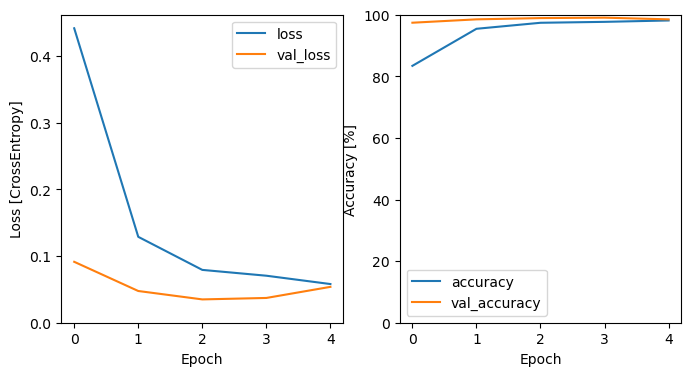

In [36]:
metrics = history.history
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]');

## 模型評估

In [37]:
model.evaluate(test_mfcc_ds, return_dict=True)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9892 - loss: 0.0386


{'accuracy': 0.9869791865348816, 'loss': 0.04721050336956978}

## 顯示混淆矩陣(Confusion matrix)

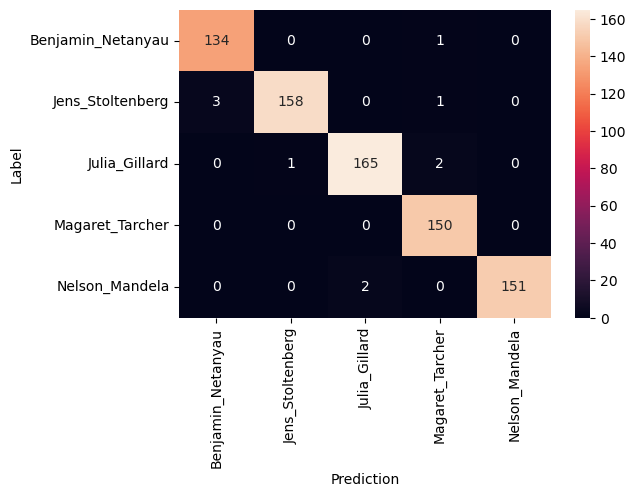

In [38]:
y_pred = model.predict(test_mfcc_ds, verbose=False)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_mfcc_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## 實際測試一個檔案

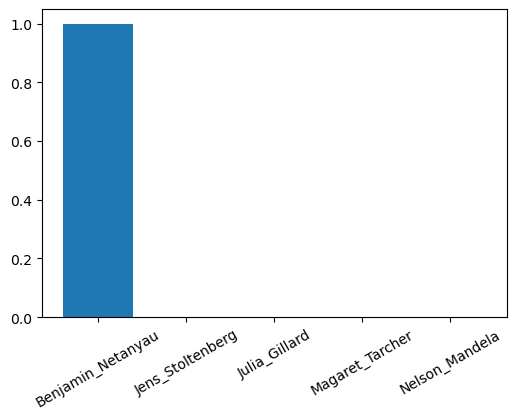

In [39]:
x = DATASET_PATH + '/Benjamin_Netanyau/0.wav'
x = tf.io.read_file(x)
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, 
                                     desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_mfcc(x, 16_000)
x = x[tf.newaxis,...]

prediction = model(x)
plt.figure(figsize=(6, 4))
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.xticks(rotation=30)
plt.show()